# <h1><center> NZ radar raw data connector </center></h1>

Author: Sebastien Delaux

This notebook describes how to work with the raw radar files produced by the MetServices rain radar network. It shows how to read them and interact with the key quantities to plot the data.
The last part of this notebook shows how multiple radar files (files corresponding to different locations). Can be blended to create a composite 3D or 2D gridded version of the data.

MetService is in the process of deciding under which license the data will be made available. For now only a few sample files have been added to this repository for illustration purposes. Please contact the author to arrange access to a larger sample of files.

## Python libraries

We install pyart which is a python library specilised in dealing with raw radar data. We also load matplotlib which will be used to generate plots.

In [2]:
import sys
!{sys.executable} -m pip install arm-pyart matplotlib

  Using cached https://files.pythonhosted.org/packages/93/4b/52da6b1523d5139d04e02d9e26ceda6146b48f2a4e5d2abfdf1c7bac8c40/matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5d/bc/1e58593167fade7b544bfe9502a26dc860940a79ab306e651e7f13be68c2/pyparsing-2.4.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/08/a549ba8b061005bb629b76adc000f3caaaf881028b963c2e18f811c6edc1/numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using

In [3]:
import pyart
from matplotlib import pyplot as plt
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:370: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


## Reading the raw radar data
The New Zealand MetService's radar data are generated by a network of 8 doppler radars spread around New Zealand. Each radar does a scan of it's surroundings every 7 to 8 minutes. The radar operate independantly and produce one file for every scan.

Let's read one of the example files and look at the structure of the data.
First we use pyart to load the data in the shape of a radar object.

In [4]:
file = './sample_data/BOP170101000556.RAWSURV'
radar = pyart.io.read(file)

The documentation for radar object just loaded can be found here: http://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.core.Radar.html#pyart.core.Radar

The radar files contain polar data from two sweeps (two revolution of the radar beam each for a different vertical angle). Each sweep contains data over a number of rays (angle) and gates (segments in the radial direction). Informations about the content of the file can be found using the info function of the radar object.

In [5]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (840,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (840,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	total_power:
		data: <ndarray of type: float32 and shape: (840, 1000)>
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		long_name: Total power
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	reflectivity:
		data: <ndarray of type: float32 and shape: (840, 1000)>
		units: dBZ
		st

## Plotting the raw data

The raw data from the two sweeps are stored in a single two dimensional array. They can be plotted in the form of two polar plots.

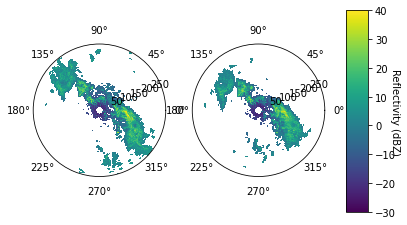

In [6]:
%matplotlib inline

# Create nsweeps polar plots
fig, axs = plt.subplots(1, radar.nsweeps, subplot_kw=dict(polar=True))


# For each plot find start and end indices
for ax, istart, iend in zip(axs.flat, radar.sweep_start_ray_index['data'], radar.sweep_end_ray_index['data']):
    # Convert azimuth to geometric angle
    geometric_angle = -(radar.azimuth['data'][istart:iend+1]/180.*np.pi+0.5*np.pi)
    
    # Create grid from indices
    R, T = np.meshgrid(radar.range['data']/1000., geometric_angle)
    
    # Plot data on grid
    im = ax.pcolor(T,R,radar.fields['reflectivity']['data'][istart:iend+1,:], vmin=-30, vmax=40)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Reflectivity (dBZ)", rotation=270)

Those two plots allow to get a good idea of the horizontal spreading of the reflectivity field. However the data recorded by the radar is three-dimensional and slightly spread over time. Indeed, as shows below it takes about 1 minute for the two sweeps to be recorded.

Text(0.5, 0, 'ID for ray')

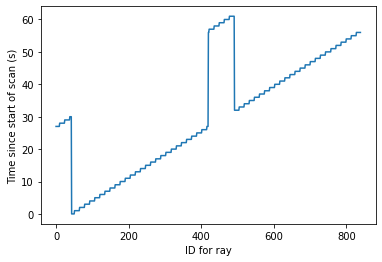

In [7]:
%matplotlib inline

plt.plot(radar.time['data'])
plt.ylabel("Time since start of scan (s)")
plt.xlabel("ID for ray")

## Gridded composite radar fields

Though the radars are not fully in sync, the frequency at which they perform their scans is about 7 minutes and in many cases it is OK to assume that all the nearest measurments in time of all New Zealand radars can be collated together to create a snapshot representation of the reflectivity field all over New Zealand at a given time. In that case we have to depart from a polar few of the reflectivity field and blend the data from the different radar over a rectilinear grid.
The present section gives an example of how two radar files, one coming from the Auckland radar (AKL...) and one coming from the Bay of Plenty radar (BOP...) can be blended together onto a single grid. In the process some minor filtering is applied to the data. An azimithal equidistant projection with longitude/latitude origin (175.5, -37.0) output coordinate system is used as well as 41 levels in the vertical. More information on the regridding function can be found here: https://arm-doe.github.io/pyart/API/generated/pyart.map.grid_from_radars.html#pyart.map.grid_from_radars

In [8]:
# Path to the 2 files to collate
radar_files = ['./sample_data/AKL170101000558.RAWSURV', './sample_data/BOP170101000556.RAWSURV']

# Loading the data
radars = [pyart.io.read(file) for file in radar_files]

# Set filters for the radar object
filters = []
for radar in radars:
    gatefilter = pyart.correct.despeckle.despeckle_field(radar, 'reflectivity',
                                                         threshold=-100, size=20)
    gatefilter.exclude_transition()
    gatefilter.exclude_above('reflectivity', 80)
    filters.append(gatefilter)
    
# Do regridding    
grid = pyart.map.grid_from_radars(radars, gatefilters=filters,
                                  grid_shape= (41, 2250, 2000),
                                  grid_limits= ([0.0, 20000.0], [-460000.0, 460000.0], [-400000.0, 400000.0]),
                                  fields=['reflectivity'],
                                  max_refl= 80.,
                                  copy_field_data= True,
                                  grid_origin= (-37.0, 175.5),
                                  roi_func= 'dist_beam',
                                  min_radius= 500.0,
                                  h_factor= 1.0,
                                  nb= 1.0,
                                  bsp= 1.0
                                 )


/home/sebastien/.local/lib/python3.6/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


Now we can plot five cross-sections of the gridded data at 5 fixes vertical levels (every 10 vertical levels of the grid). And get an idea of the 3D structure of the data.

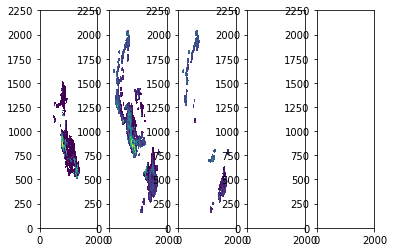

In [9]:
%matplotlib inline
fig, axs = plt.subplots(1, 5)

for ax, data in zip(axs.flat, grid.fields['reflectivity']['data'][::10,:,:]):
    ax.pcolor(data, vmin=0, vmax=35)

We can also plot cross-sections along the north-south and east-west directiontp get an idea of the vertical structure of the data

[Text(0.5, 0, 'Distance from radar')]

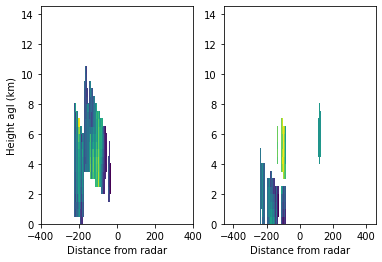

In [12]:
%matplotlib inline

fig, axs = plt.subplots(1, 2)

ax = axs.flat[0]
ax.pcolor(grid.x['data']/1000., grid.z['data'][:30]/1000.,
                 grid.fields['reflectivity']['data'][:30,1125,:])
ax.set(xlabel="Distance from radar", ylabel="Height agl (km)")


ax = axs.flat[1]
plot = ax.pcolor(grid.y['data']/1000., grid.z['data'][:30]/1000.,
          grid.fields['reflectivity']['data'][:30,:,1000])
ax.set(xlabel="Distance from radar")



3D data can be quite heavy to work with and something one only consider the maximum reflectivity over the atmospheric column.

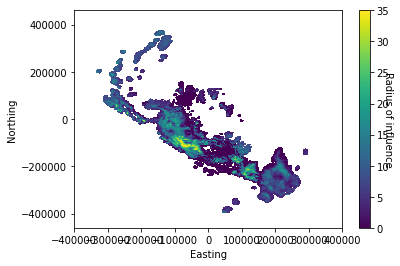

In [13]:
%matplotlib inline

plt.pcolor(grid.x['data'], grid.y['data'],
           np.amax(grid.fields['reflectivity']['data'][:,:,:], axis=0), vmin=0, vmax=35)
plt.xlabel('Easting')
plt.ylabel('Northing')
cbar = plt.colorbar()
cbar.set_label("Radius of influence", rotation=270)


One can always keep some information on the vertical structure by storing the height at which the maximum in reflectivity was found

In [14]:
max_reflectivity_height = grid.z['data'][np.argmax(grid.fields['reflectivity']['data'][:,:,:], axis=0)]

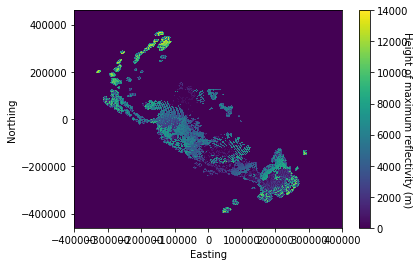

In [15]:
%matplotlib inline

plt.pcolor(grid.x['data'], grid.y['data'], max_reflectivity_height)
plt.xlabel('Easting')
plt.ylabel('Northing')
cbar = plt.colorbar()
cbar.set_label("Height of maximum reflectivity (m)", rotation=270)

An additional field that is produced during the regridding process is the radius of influence. This quantify the distance between the data point in the grid and the instrument that recorded it. This is an important quantity as the resolution and hence quality of the data drops with the distance from the instrument.
On the plot below one can clearly see that two sources were used to created the grid, their location and how the radius of influence increases with the distance from the radars.

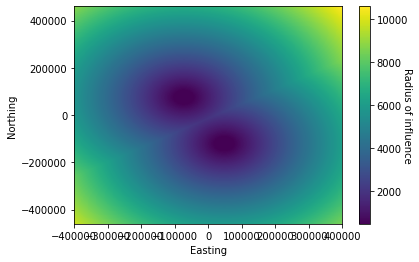

In [16]:
%matplotlib inline

plt.pcolor(grid.x['data'], grid.y['data'], grid.fields['ROI']['data'][0,:,:])
plt.xlabel('Easting')
plt.ylabel('Northing')
cbar = plt.colorbar()
cbar.set_label("Radius of influence", rotation=270)